In [578]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# 1. Load datasets and Similarity matrices

In [659]:
# load databases
df_publications = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/dataset/publications_topics.parquet')
df_eic = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/dataset/eic_topics.parquet')
df_horizon = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/dataset/horizon_topics.parquet')
df_publications_researchers = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/data_ingest/UC3M ResearchPortal/Outputs/researchers_publications.parquet')
df_researchers = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/data_ingest/UC3M ResearchPortal/Outputs/researchers.parquet')

# join together al the calls (igual que cuando creamos las matrices de similitud)
df_eic['Call'] = df_eic['id']
df_calls = pd.concat([df_horizon[['Call', 'tpc_decomposition']], df_eic[['Call', 'tpc_decomposition']]], axis=0).reset_index(drop=True)

In [660]:
# load similarity matrixs
sim_matrix_embeddings = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices/cosine_sim_matrix_we_doc2vec.parquet')
sim_matrix_BERT = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices/cosine_sim_matrix_we_BERT.parquet')
sim_matrix_tfidf = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices/cosine_sim_matrix_tfidf.parquet')
sim_matrix_bhattacharyya = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices/bhattacharyya_sim_matrix.parquet')


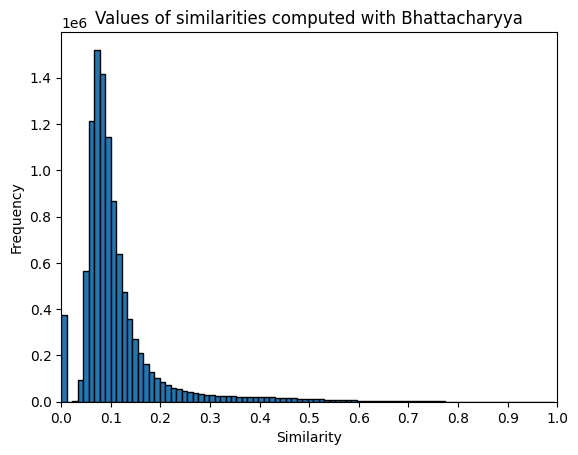

In [679]:
all_numeric_values = sim_matrix_bhattacharyya.select_dtypes(include='number').values.flatten()

# Crear un histograma para todos los valores numéricos
plt.hist(all_numeric_values, bins=90, edgecolor='black')
plt.xlim(0, 1)

# Utilizar numpy.arange() para generar ticks con incrementos decimales
plt.xticks(np.arange(0, 1.1, 0.1))

plt.title('Values of similarities computed with Bhattacharyya')
plt.xlabel('Similarity')
plt.ylabel('Frequency')

plt.show()

In [680]:
# theshold the simmilarities 
sim_matrix_embeddings = sim_matrix_embeddings.mask(sim_matrix_embeddings < 0.6, 0)
sim_matrix_BERT = sim_matrix_BERT.mask(sim_matrix_BERT < 0.3, 0)
sim_matrix_tfidf = sim_matrix_tfidf.mask(sim_matrix_tfidf < 0.025, 0)
sim_matrix_bhattacharyya = sim_matrix_bhattacharyya.mask(sim_matrix_bhattacharyya < 0.1, 0)

# 2. Get simmilarities for researchers

In [681]:
def get_similarity_publication(sim_matrix, df_publications):
    '''
    Function for getting a dataset with the id of each of the publications and the similarity with each of the calls
    
    sim_matrix -> similarity matrix 
    df_publication -> df containing the publications 
    '''
    df = sim_matrix.reset_index()

    df['similarity'] = df.apply(lambda row: row.values[1:], axis=1)

    # Seleccionar solo las columnas 'index' e 'similarity'
    df = df[['index', 'similarity']]

    # Renombrar las columnas
    df.columns = ['actID', 'similarity']
    
    return df
        

In [663]:
df_sim_pub_embeddings =  get_similarity_publication(sim_matrix_embeddings, df_publications)
df_sim_pub_embeddings_BERT =  get_similarity_publication(sim_matrix_BERT, df_publications)
df_sim_pub_tfidf =  get_similarity_publication(sim_matrix_tfidf, df_publications)
df_sim_pub_bhattacharyya =  get_similarity_publication(sim_matrix_bhattacharyya, df_publications)

In [664]:
def agg_mean_imp(df):
    '''
    Function for computing the aggregated of all the similarities of  an author considering only the not thresholded ones
    
    df -> df containing all the similarities without aggreating 
    '''
    
    result_df = pd.DataFrame(columns=['invID', 'similarity'])
    invIDs = df['invID'].unique()

    for invID in tqdm(invIDs, desc="Processing invIDs", unit="invID"):
        df_researcher = df[df['invID'] == invID]
        df_vectores_sim = pd.DataFrame(df_researcher['similarity'].tolist())

        suma_columnas = df_vectores_sim.sum()
        non_zero = df_vectores_sim.apply(lambda col: col[col != 0].count())
        mean_imp = (suma_columnas / non_zero).to_list()

        row = pd.DataFrame(data=[[invID, mean_imp]], columns=['invID', 'similarity'])
        result_df = pd.concat([result_df, row])

    return result_df


In [665]:
df_pub_res_sim_embeddings = pd.merge(df_publications_researchers, df_sim_pub_embeddings, on='actID', how='inner')
df_pub_res_sim_embeddings_sum = df_pub_res_sim_embeddings.groupby('invID')['similarity'].sum().reset_index()
df_pub_res_sim_embeddings_mean = df_pub_res_sim_embeddings.groupby('invID')['similarity'].apply(lambda x: pd.Series(x.values.tolist()).mean()).reset_index()
df_pub_res_sim_embeddings_mean_imp = agg_mean_imp(df_pub_res_sim_embeddings)

df_pub_res_sim_BERT = pd.merge(df_publications_researchers, df_sim_pub_embeddings_BERT, on='actID', how='inner')
df_pub_res_sim_BERT_sum = df_pub_res_sim_BERT.groupby('invID')['similarity'].sum().reset_index()
df_pub_res_sim_BERT_mean = df_pub_res_sim_BERT.groupby('invID')['similarity'].apply(lambda x: pd.Series(x.values.tolist()).mean()).reset_index()
df_pub_res_sim_BERT_mean_imp = agg_mean_imp(df_pub_res_sim_BERT)

df_pub_res_sim_tfidf = pd.merge(df_publications_researchers, df_sim_pub_tfidf, on='actID', how='inner')
df_pub_res_sim_tfidf_sum = df_pub_res_sim_tfidf.groupby('invID')['similarity'].sum().reset_index()
df_pub_res_sim_tfidf_mean = df_pub_res_sim_tfidf.groupby('invID')['similarity'].apply(lambda x: pd.Series(x.values.tolist()).mean()).reset_index()
df_pub_res_sim_tfidf_mean_imp = agg_mean_imp(df_pub_res_sim_tfidf)

df_pub_res_sim_bhattacharyya = pd.merge(df_publications_researchers, df_sim_pub_bhattacharyya, on='actID', how='inner')
df_pub_res_sim_bhattacharyya_sum = df_pub_res_sim_bhattacharyya.groupby('invID')['similarity'].sum().reset_index()
df_pub_res_sim_bhattacharyya_mean = df_pub_res_sim_bhattacharyya.groupby('invID')['similarity'].apply(lambda x: pd.Series(x.values.tolist()).mean()).reset_index()
df_pub_res_sim_bhattacharyya_mean_imp = agg_mean_imp(df_pub_res_sim_bhattacharyya)


Processing invIDs: 100%|██████████| 1129/1129 [01:42<00:00, 10.98invID/s]


In [683]:
df_pub_res_sim_bhattacharyya = pd.merge(df_publications_researchers, df_sim_pub_bhattacharyya, on='actID', how='inner')
df_pub_res_sim_bhattacharyya_sum = df_pub_res_sim_bhattacharyya.groupby('invID')['similarity'].sum().reset_index()
df_pub_res_sim_bhattacharyya_mean = df_pub_res_sim_bhattacharyya.groupby('invID')['similarity'].apply(lambda x: pd.Series(x.values.tolist()).mean()).reset_index()
df_pub_res_sim_bhattacharyya_mean_imp = agg_mean_imp(df_pub_res_sim_bhattacharyya)


Processing invIDs: 100%|██████████| 1129/1129 [01:42<00:00, 10.96invID/s]


# 3. Create similarity matrices for researchers and calls

In [690]:
def get_sim_matrix(df_calls, df_researchers):
    '''
    Function for computing the similarity matrix for the researchers and the calls
    
    df_calls -> dataframe with all the avaliable calls
    df_researchers -> Dataframe containing the researchers and the similarity with each of the publications
    '''
    
    keys_calls = df_calls['Call'].tolist()
    keys_res = df_researchers['invID'].tolist()
    sim = df_researchers['similarity'].tolist()
    
    df = pd.DataFrame(sim, columns=keys_calls, index=keys_res)
    
    return df



In [691]:
similarity_embeddings_sum = get_sim_matrix(df_calls, df_pub_res_sim_embeddings_sum)
similarity_BERT_sum = get_sim_matrix(df_calls, df_pub_res_sim_BERT_sum)
similarity_tfidf_sum = get_sim_matrix(df_calls, df_pub_res_sim_tfidf_sum)
similarity_battacharyya_sum = get_sim_matrix(df_calls, df_pub_res_sim_bhattacharyya_sum)

similarity_embeddings_mean = get_sim_matrix(df_calls, df_pub_res_sim_embeddings_mean)
similarity_BERT_mean = get_sim_matrix(df_calls, df_pub_res_sim_BERT_mean)
similarity_tfidf_mean = get_sim_matrix(df_calls, df_pub_res_sim_tfidf_mean)
similarity_battacharyya_mean = get_sim_matrix(df_calls, df_pub_res_sim_bhattacharyya_mean)

similarity_embeddings_mean_imp = get_sim_matrix(df_calls, df_pub_res_sim_embeddings_mean_imp)
similarity_BERT_mean_imp = get_sim_matrix(df_calls, df_pub_res_sim_BERT_mean_imp)
similarity_tfidf_mean_imp = get_sim_matrix(df_calls, df_pub_res_sim_tfidf_mean_imp)
similarity_battacharyya_mean_imp = get_sim_matrix(df_calls, df_pub_res_sim_bhattacharyya_mean_imp)

In [692]:
similarity_embeddings_sum.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_embeddings_sum.parquet')
similarity_BERT_sum.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_BERT_sum.parquet')
similarity_tfidf_sum.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_tfidf_sum.parquet')
similarity_battacharyya_sum.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_bhattacharyya_sum.parquet')

similarity_embeddings_mean.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_embeddings_mean.parquet')
similarity_BERT_mean.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_BERT_mean.parquet')
similarity_tfidf_mean.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_tfidf_mean.parquet')
similarity_battacharyya_mean.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_bhattacharyya_mean.parquet')

similarity_embeddings_mean_imp.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_embeddings_mean_imp.parquet')
similarity_BERT_mean_imp.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_BERT_mean_imp.parquet')
similarity_tfidf_mean_imp.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_tfidf_mean_imp.parquet')
similarity_battacharyya_mean_imp.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_bhattacharyya_mean_imp.parquet')

# 4. perform the match 

In [687]:
def match(similarities, call, df_researchers, n=1129):
    '''
    Function for obtaining the ranking of researchers given a call 
    
    similarities -> df with all the smmilarities between researchers and calls
    call -> Call of interest
    n -> Number of researchers we are interested in 
    df_researchers -> Dataframe with the information about the researchers
    '''
    
    ranking = similarities[call].sort_values(ascending=False).fillna(0)
    ranking = pd.DataFrame(ranking).reset_index()
    id_researchers = ranking['index'].to_list()
    similarities = ranking[call].to_list()
    id_researchers = pd.DataFrame({'invID': id_researchers, 'similarity': similarities})
    df_ranking_researchers = pd.merge(id_researchers, df_researchers, on='invID', how='inner')

    return df_ranking_researchers.head(n)

def recommendation_system(method, agg_method, call, researchers, n=1129,
                         path='/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_{}_{}.parquet'):
    '''
    function for obtaining the recommendations
    
    path -> Path to the file containing the similarity matrix
    method -> Method selected to calculate the similarities 
    agg_method -> Agregation method selected for calculating the similarties between calls and researchers
    '''
    
    similarities = pd.read_parquet(path.format(method, agg_method))
    ranking = match(similarities, call, researchers, n)
    return ranking[['invID', 'Name', 'Department', 'Research Group', 'Subjects', 'no Publis', 'similarity']]

In [694]:
ranking = recommendation_system(method='bhattacharyya', agg_method='mean_imp', call='HORIZON-CL6-2023-CLIMATE-01-7', researchers=df_researchers, n=6)
ranking

,invID,Name,Department,Research Group,Subjects,no Publis,similarity
0,inv39621,"Briz Pacheco, Susana",Physics,Laboratorio de Sensores Teledetección e Imagen...,"[Computer Science, Education, Electronics, Ind...",35,0.607538
1,inv37778,"Sanz Sanchez, Susana",Mechanical Engineering,"Experimental Mechanics, Calculations and Trans...","[Electronics, Environment, Industrial Engineer...",20,0.577031
2,inv37512,"Fernandez Garcia, Eva",Social Sciences,Histories of Global Latin Capitalisms (H-GLACIAL),"[Economics, History]",12,0.547136
3,inv17457,"Carmona Pidal, Juan Antonio",Social Sciences,Political Economy of Institutions and Conflict,"[Economics, History]",41,0.424360
4,inv15989,"Santana Santana, Domingo Jose",Thermal and Fluids Engineering,Appropriate Technologies for Sustainable Devel...,"[Chemistry, Electronics, Industrial Engineerin...",134,0.404092
5,inv16057,"Povedano Marrugat, Elisa Maria","Humanities: History, Geography, and Art",Contemporary Studies,"[Architecture, Art, Environment, History of Ar...",27,0.397097


Processing calls: 100%|██████████| 1/1 [00:00<00:00,  4.50call/s]


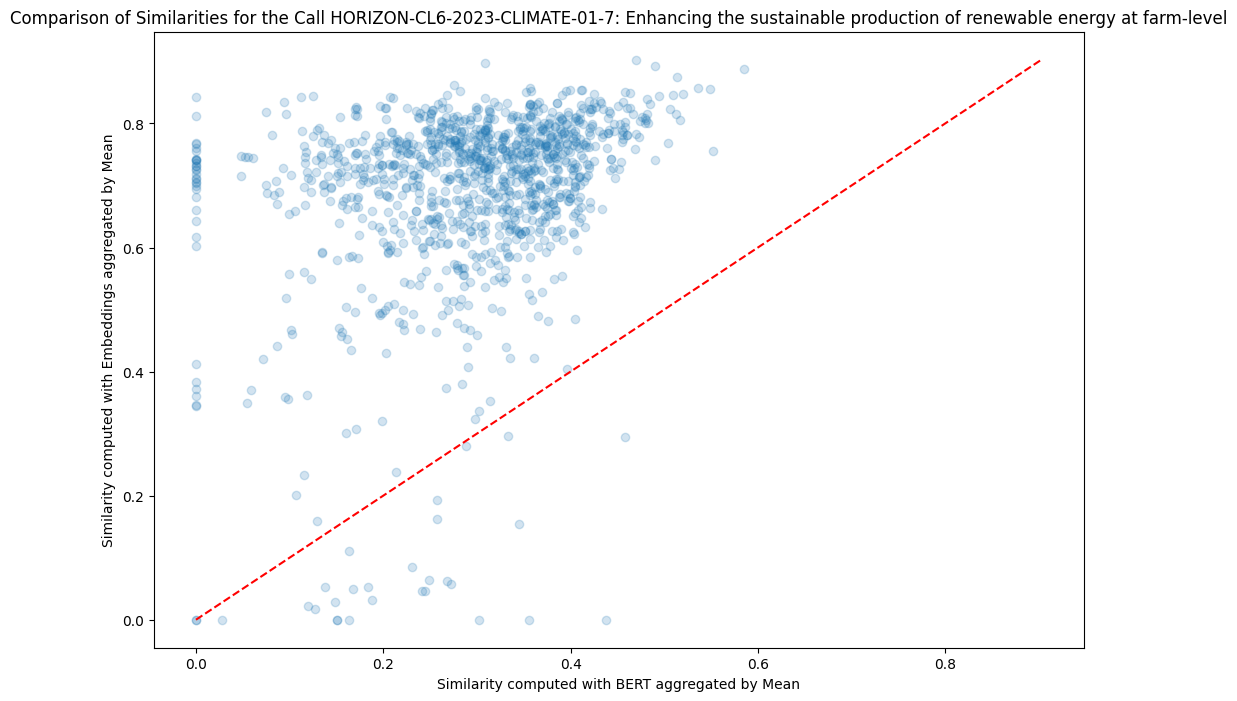

In [658]:
plot_ranking('BERT', 'mean', 'embeddings', 'mean', 'BERT aggregated by Mean', 'Embeddings aggregated by Mean', calls=['HORIZON-CL6-2023-CLIMATE-01-7'])


In [642]:
calls = df_horizon['Call'].unique()
def df_to_plot_ranking(method_1, agg_method_1, method_2, agg_method_2, calls=calls, df_researchers=df_researchers):
    complete_ranking = pd.DataFrame(columns=['invID', 'Call', 'similarity_1', 'similarity_2'])
    for call in tqdm(calls, desc="Processing calls", unit="call"):
        ranking_1 = recommendation_system(method=method_1, agg_method=agg_method_1, call=call, researchers=df_researchers)[['invID', 'similarity']]
        ranking_2 = recommendation_system(method=method_2, agg_method=agg_method_2, call=call, researchers=df_researchers)[['invID', 'similarity']]

        ranking = pd.merge(ranking_1, ranking_2, on='invID', suffixes=('_1', '_2'))
        ranking['Call'] = call
        complete_ranking = pd.concat([complete_ranking, ranking])
    
    return complete_ranking
        
    
        

def plot_ranking(method_1, agg_method_1, method_2, agg_method_2, label_1, label_2, calls=calls, df_researchers=df_researchers):
    complete_ranking = df_to_plot_ranking(method_1, agg_method_1, method_2, agg_method_2, calls=calls, df_researchers=df_researchers)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = plt.scatter(complete_ranking['similarity_1'], complete_ranking['similarity_2'], alpha=0.2)
    ax.set_xlabel('Similarity computed with {}'.format(label_1))
    ax.set_ylabel('Similarity computed with {}'.format(label_2))
    ax.set_title('Comparison of Similarities for the Call HORIZON-CL6-2023-CLIMATE-01-7: Enhancing the sustainable production of renewable energy at farm-level')
    
    min_val = min(complete_ranking['similarity_1'].min(), complete_ranking['similarity_2'].min())
    max_val = max(complete_ranking['similarity_1'].max(), complete_ranking['similarity_2'].max())
    bisectrix_line = np.linspace(min_val, max_val, 100)
    plt.plot(bisectrix_line, bisectrix_line, color='red', linestyle='--', label='Bisectrix')


    #plt.savefig('results/plot {} {}.png'.format(label_1, label_2))
    plt.show()


In [ ]:
for i in config:
    method_1 = i['method_1']
    method_2 = i['method_2']
    agg_method_1 = i['agg_method_1']
    agg_method_2 = i['agg_method_2']
    label_1 = i['label_1']
    label_2 = i['label_2']
    
    plot_ranking(method_1, agg_method_1, method_2, agg_method_2, label_1, label_2)
    

In [584]:
config = [
    {'method_1':'embeddings', 'agg_method_1':'sum', 'method_2':'embeddings', 'agg_method_2':'mean', 'label_1':'Embeddings aggregated by Sum', 'label_2':'Embeddings aggregated by Mean'}, 
    {'method_1':'embeddings', 'agg_method_1':'sum', 'method_2':'embeddings', 'agg_method_2':'mean_imp', 'label_1':'Embeddings aggregated by Sum', 'label_2':'Embeddings aggregated by Mean of Thresholded values'},
    {'method_1':'embeddings', 'agg_method_1':'mean', 'method_2':'embeddings', 'agg_method_2':'sum', 'label_1':'Embeddings aggregated by Mean', 'label_2':'Embeddings aggregated by Sum'},
    {'method_1':'embeddings', 'agg_method_1':'mean', 'method_2':'embeddings', 'agg_method_2':'mean_imp', 'label_1':'Embeddings aggregated by Mean', 'label_2':'Embeddings aggregated by Mean of Thresholded values'},
    {'method_1':'embeddings', 'agg_method_1':'mean_imp', 'method_2':'embeddings', 'agg_method_2':'sum', 'label_1':'Embeddings aggregated by Mean of Thresholded values', 'label_2':'Embeddings aggregated by Sum'},
    {'method_1':'embeddings', 'agg_method_1':'mean_imp', 'method_2':'embeddings', 'agg_method_2':'mean', 'label_1':'Embeddings aggregated by Mean of Thresholded values', 'label_2':'Embeddings aggregated by Mean'}, 

    {'method_1':'embeddings', 'agg_method_1':'sum', 'method_2':'BERT', 'agg_method_2':'sum', 'label_1':'Embeddings aggregated by Sum', 'label_2':'BERT aggregated by Sum'},
    {'method_1':'embeddings', 'agg_method_1':'sum', 'method_2':'BERT', 'agg_method_2':'mean', 'label_1':'Embeddings aggregated by Sum', 'label_2':'BERT aggregated by Mean'}, 
    {'method_1':'embeddings', 'agg_method_1':'sum', 'method_2':'BERT', 'agg_method_2':'mean_imp', 'label_1':'Embeddings aggregated by Sum', 'label_2':'BERT aggregated by Mean of Thresholded values'},
    {'method_1':'embeddings', 'agg_method_1':'mean', 'method_2':'BERT', 'agg_method_2':'sum', 'label_1':'Embeddings aggregated by Mean', 'label_2':'BERT aggregated by Sum'},
    {'method_1':'embeddings', 'agg_method_1':'mean', 'method_2':'BERT', 'agg_method_2':'mean', 'label_1':'Embeddings aggregated by Mean', 'label_2':'BERT aggregated by Mean'}, 
    {'method_1':'embeddings', 'agg_method_1':'mean', 'method_2':'BERT', 'agg_method_2':'mean_imp', 'label_1':'Embeddings aggregated by Mean', 'label_2':'BERT aggregated by Mean of Thresholded values'},
    {'method_1':'embeddings', 'agg_method_1':'mean_imp', 'method_2':'BERT', 'agg_method_2':'sum', 'label_1':'Embeddings aggregated by Mean of Thresholded values', 'label_2':'BERT aggregated by Sum'},
    {'method_1':'embeddings', 'agg_method_1':'mean_imp', 'method_2':'BERT', 'agg_method_2':'mean', 'label_1':'Embeddings aggregated by Mean of Thresholded values', 'label_2':'BERT aggregated by Mean'}, 
    {'method_1':'embeddings', 'agg_method_1':'mean_imp', 'method_2':'BERT', 'agg_method_2':'mean_imp', 'label_1':'Embeddings aggregated by Mean of Thresholded values', 'label_2':'BERT aggregated by Mean of Thresholded values'},

    {'method_1':'embeddings', 'agg_method_1':'sum', 'method_2':'tfidf', 'agg_method_2':'mean', 'label_1':'Embeddings aggregated by Sum', 'label_2':'tfidf aggregated by Mean'}, 
    {'method_1':'embeddings', 'agg_method_1':'sum', 'method_2':'tfidf', 'agg_method_2':'mean_imp', 'label_1':'Embeddings aggregated by Sum', 'label_2':'tfidf aggregated by Mean of Thresholded values'},
    {'method_1':'embeddings', 'agg_method_1':'mean', 'method_2':'tfidf', 'agg_method_2':'sum', 'label_1':'Embeddings aggregated by Mean', 'label_2':'tfidf aggregated by Sum'},
    {'method_1':'embeddings', 'agg_method_1':'mean', 'method_2':'tfidf', 'agg_method_2':'mean', 'label_1':'Embeddings aggregated by Mean', 'label_2':'tfidf aggregated by Mean'}, 
    {'method_1':'embeddings', 'agg_method_1':'mean', 'method_2':'tfidf', 'agg_method_2':'mean_imp', 'label_1':'Embeddings aggregated by Mean', 'label_2':'tfidf aggregated by Mean of Thresholded values'},
    {'method_1':'embeddings', 'agg_method_1':'mean_imp', 'method_2':'tfidf', 'agg_method_2':'sum', 'label_1':'Embeddings aggregated by Mean of Thresholded values', 'label_2':'tfidf aggregated by Sum'},
    {'method_1':'embeddings', 'agg_method_1':'mean_imp', 'method_2':'tfidf', 'agg_method_2':'mean', 'label_1':'Embeddings aggregated by Mean of Thresholded values', 'label_2':'tfidf aggregated by Mean'}, 
    {'method_1':'embeddings', 'agg_method_1':'mean_imp', 'method_2':'tfidf', 'agg_method_2':'mean_imp', 'label_1':'Embeddings aggregated by Mean of Thresholded values', 'label_2':'tfidf aggregated by Mean of Thresholded values'},

    {'method_1':'embeddings', 'agg_method_1':'sum', 'method_2':'bhattacharyya', 'agg_method_2':'mean', 'label_1':'Embeddings aggregated by Sum', 'label_2':'bhattacharyya aggregated by Mean'}, 
    {'method_1':'embeddings', 'agg_method_1':'sum', 'method_2':'bhattacharyya', 'agg_method_2':'mean_imp', 'label_1':'Embeddings aggregated by Sum', 'label_2':'bhattacharyya aggregated by Mean of Thresholded values'},
    {'method_1':'embeddings', 'agg_method_1':'mean', 'method_2':'bhattacharyya', 'agg_method_2':'sum', 'label_1':'Embeddings aggregated by Mean', 'label_2':'bhattacharyya aggregated by Sum'},
    {'method_1':'embeddings', 'agg_method_1':'mean', 'method_2':'bhattacharyya', 'agg_method_2':'mean', 'label_1':'Embeddings aggregated by Mean', 'label_2':'bhattacharyya aggregated by Mean'}, 
    {'method_1':'embeddings', 'agg_method_1':'mean', 'method_2':'bhattacharyya', 'agg_method_2':'mean_imp', 'label_1':'Embeddings aggregated by Mean', 'label_2':'bhattacharyya aggregated by Mean of Thresholded values'},
    {'method_1':'embeddings', 'agg_method_1':'mean_imp', 'method_2':'bhattacharyya', 'agg_method_2':'sum', 'label_1':'Embeddings aggregated by Mean of Thresholded values', 'label_2':'bhattacharyya aggregated by Sum'},
    {'method_1':'embeddings', 'agg_method_1':'mean_imp', 'method_2':'bhattacharyya', 'agg_method_2':'mean', 'label_1':'Embeddings aggregated by Mean of Thresholded values', 'label_2':'bhattacharyya aggregated by Mean'}, 
    {'method_1':'embeddings', 'agg_method_1':'mean_imp', 'method_2':'bhattacharyya', 'agg_method_2':'mean_imp', 'label_1':'Embeddings aggregated by Mean of Thresholded values', 'label_2':'bhattacharyya aggregated by Mean of Thresholded values'},

    {'method_1':'BERT', 'agg_method_1':'sum', 'method_2':'BERT', 'agg_method_2':'mean', 'label_1':'BERT aggregated by Sum', 'label_2':'BERT aggregated by Mean'}, 
    {'method_1':'BERT', 'agg_method_1':'sum', 'method_2':'BERT', 'agg_method_2':'mean_imp', 'label_1':'BERT aggregated by Sum', 'label_2':'BERT aggregated by Mean of Thresholded values'},
    {'method_1':'BERT', 'agg_method_1':'mean', 'method_2':'BERT', 'agg_method_2':'sum', 'label_1':'BERT aggregated by Mean', 'label_2':'BERT aggregated by Sum'},
    {'method_1':'BERT', 'agg_method_1':'mean', 'method_2':'BERT', 'agg_method_2':'mean_imp', 'label_1':'BERT aggregated by Mean', 'label_2':'BERT aggregated by Mean of Thresholded values'},
    {'method_1':'BERT', 'agg_method_1':'mean_imp', 'method_2':'BERT', 'agg_method_2':'sum', 'label_1':'BERT aggregated by Mean of Thresholded values', 'label_2':'BERT aggregated by Sum'},
    {'method_1':'BERT', 'agg_method_1':'mean_imp', 'method_2':'BERT', 'agg_method_2':'mean', 'label_1':'BERT aggregated by Mean of Thresholded values', 'label_2':'BERT aggregated by Mean'}, 

    
    {'method_1':'BERT', 'agg_method_1':'sum', 'method_2':'tfidf', 'agg_method_2':'sum', 'label_1':'BERT aggregated by Sum', 'label_2':'tfidf aggregated by Sum'},
    {'method_1':'BERT', 'agg_method_1':'sum', 'method_2':'tfidf', 'agg_method_2':'mean', 'label_1':'BERT aggregated by Sum', 'label_2':'tfidf aggregated by Mean'},
    {'method_1':'BERT', 'agg_method_1':'sum', 'method_2':'tfidf', 'agg_method_2':'mean_imp', 'label_1':'BERT aggregated by Sum', 'label_2':'tfidf aggregated by Mean of Thresholded values'},
    {'method_1':'BERT', 'agg_method_1':'mean', 'method_2':'tfidf', 'agg_method_2':'sum', 'label_1':'BERT aggregated by Mean', 'label_2':'tfidf aggregated by Sum'},
    {'method_1':'BERT', 'agg_method_1':'mean', 'method_2':'tfidf', 'agg_method_2':'mean', 'label_1':'BERT aggregated by Mean', 'label_2':'tfidf aggregated by Mean'},
    {'method_1':'BERT', 'agg_method_1':'mean', 'method_2':'tfidf', 'agg_method_2':'mean_imp', 'label_1':'BERT aggregated by Mean', 'label_2':'tfidf aggregated by Mean of Thresholded values'},
    {'method_1':'BERT', 'agg_method_1':'mean_imp', 'method_2':'tfidf', 'agg_method_2':'sum', 'label_1':'BERT aggregated by Mean of Thresholded values', 'label_2':'tfidf aggregated by Sum'},
    {'method_1':'BERT', 'agg_method_1':'mean_imp', 'method_2':'tfidf', 'agg_method_2':'mean', 'label_1':'BERT aggregated by Mean of Thresholded values', 'label_2':'tfidf aggregated by Mean'},
    {'method_1':'BERT', 'agg_method_1':'mean_imp', 'method_2':'tfidf', 'agg_method_2':'mean_imp', 'label_1':'BERT aggregated by Mean of Thresholded values', 'label_2':'tfidf aggregated by Mean of Thresholded values'},

    {'method_1':'BERT', 'agg_method_1':'sum', 'method_2':'bhattacharyya', 'agg_method_2':'sum', 'label_1':'BERT aggregated by Sum', 'label_2':'bhattacharyya aggregated by Sum'},
    {'method_1':'BERT', 'agg_method_1':'sum', 'method_2':'bhattacharyya', 'agg_method_2':'mean', 'label_1':'BERT aggregated by Sum', 'label_2':'bhattacharyya aggregated by Mean'},
    {'method_1':'BERT', 'agg_method_1':'sum', 'method_2':'bhattacharyya', 'agg_method_2':'mean_imp', 'label_1':'BERT aggregated by Sum', 'label_2':'bhattacharyya aggregated by Mean of Thresholded values'},
    {'method_1':'BERT', 'agg_method_1':'mean', 'method_2':'bhattacharyya', 'agg_method_2':'sum', 'label_1':'BERT aggregated by Mean', 'label_2':'bhattacharyya aggregated by Sum'},
    {'method_1':'BERT', 'agg_method_1':'mean', 'method_2':'bhattacharyya', 'agg_method_2':'mean', 'label_1':'BERT aggregated by Mean', 'label_2':'bhattacharyya aggregated by Mean'},
    {'method_1':'BERT', 'agg_method_1':'mean', 'method_2':'bhattacharyya', 'agg_method_2':'mean_imp', 'label_1':'BERT aggregated by Mean', 'label_2':'bhattacharyya aggregated by Mean of Thresholded values'},
    {'method_1':'BERT', 'agg_method_1':'mean_imp', 'method_2':'bhattacharyya', 'agg_method_2':'sum', 'label_1':'BERT aggregated by Mean of Thresholded values', 'label_2':'bhattacharyya aggregated by Sum'},
    {'method_1':'BERT', 'agg_method_1':'mean_imp', 'method_2':'bhattacharyya', 'agg_method_2':'mean', 'label_1':'BERT aggregated by Mean of Thresholded values', 'label_2':'bhattacharyya aggregated by Mean'},
    {'method_1':'BERT', 'agg_method_1':'mean_imp', 'method_2':'bhattacharyya', 'agg_method_2':'mean_imp', 'label_1':'BERT aggregated by Mean of Thresholded values', 'label_2':'bhattacharyya aggregated by Mean of Thresholded values'},

    {'method_1':'tfidf', 'agg_method_1':'sum', 'method_2':'bhattacharyya', 'agg_method_2':'sum', 'label_1':'tfidf aggregated by Sum', 'label_2':'bhattacharyya aggregated by Sum'},
    {'method_1':'tfidf', 'agg_method_1':'sum', 'method_2':'bhattacharyya', 'agg_method_2':'mean', 'label_1':'tfidf aggregated by Sum', 'label_2':'bhattacharyya aggregated by Mean'},
    {'method_1':'tfidf', 'agg_method_1':'sum', 'method_2':'bhattacharyya', 'agg_method_2':'mean_imp', 'label_1':'tfidf aggregated by Sum', 'label_2':'bhattacharyya aggregated by Mean of Thresholded values'},
    {'method_1':'tfidf', 'agg_method_1':'mean', 'method_2':'bhattacharyya', 'agg_method_2':'sum', 'label_1':'tfidf aggregated by Mean', 'label_2':'bhattacharyya aggregated by Sum'},
    {'method_1':'tfidf', 'agg_method_1':'mean', 'method_2':'bhattacharyya', 'agg_method_2':'mean', 'label_1':'tfidf aggregated by Mean', 'label_2':'bhattacharyya aggregated by Mean'},
    {'method_1':'tfidf', 'agg_method_1':'mean', 'method_2':'bhattacharyya', 'agg_method_2':'mean_imp', 'label_1':'tfidf aggregated by Mean', 'label_2':'bhattacharyya aggregated by Mean of Thresholded values'},
    {'method_1':'tfidf', 'agg_method_1':'mean_imp', 'method_2':'bhattacharyya', 'agg_method_2':'sum', 'label_1':'tfidf aggregated by Mean of Thresholded values', 'label_2':'bhattacharyya aggregated by Sum'},
    {'method_1':'tfidf', 'agg_method_1':'mean_imp', 'method_2':'bhattacharyya', 'agg_method_2':'mean', 'label_1':'tfidf aggregated by Mean of Thresholded values', 'label_2':'bhattacharyya aggregated by Mean'},
    {'method_1':'tfidf', 'agg_method_1':'mean_imp', 'method_2':'bhattacharyya', 'agg_method_2':'mean_imp', 'label_1':'tfidf aggregated by Mean of Thresholded values', 'label_2':'bhattacharyya aggregated by Mean of Thresholded values'},
    
    {'method_1':'tfidf', 'agg_method_1':'sum', 'method_2':'tfidf', 'agg_method_2':'mean', 'label_1':'tfidf aggregated by Sum', 'label_2':'tfidf aggregated by Mean'}, 
    {'method_1':'tfidf', 'agg_method_1':'sum', 'method_2':'tfidf', 'agg_method_2':'mean_imp', 'label_1':'tfidf aggregated by Sum', 'label_2':'tfidf aggregated by Mean of Thresholded values'},
    {'method_1':'tfidf', 'agg_method_1':'mean', 'method_2':'tfidf', 'agg_method_2':'sum', 'label_1':'tfidf aggregated by Mean', 'label_2':'tfidf aggregated by Sum'},
    {'method_1':'tfidf', 'agg_method_1':'mean', 'method_2':'tfidf', 'agg_method_2':'mean_imp', 'label_1':'tfidf aggregated by Mean', 'label_2':'tfidf aggregated by Mean of Thresholded values'},
    {'method_1':'tfidf', 'agg_method_1':'mean_imp', 'method_2':'tfidf', 'agg_method_2':'sum', 'label_1':'tfidf aggregated by Mean of Thresholded values', 'label_2':'tfidf aggregated by Sum'},
    {'method_1':'tfidf', 'agg_method_1':'mean_imp', 'method_2':'tfidf', 'agg_method_2':'mean', 'label_1':'tfidf aggregated by Mean of Thresholded values', 'label_2':'tfidf aggregated by Mean'}, 
    
    {'method_1':'bhattacharyya', 'agg_method_1':'sum', 'method_2':'bhattacharyya', 'agg_method_2':'mean', 'label_1':'bhattacharyya aggregated by Sum', 'label_2':'bhattacharyya aggregated by Mean'}, 
    {'method_1':'bhattacharyya', 'agg_method_1':'sum', 'method_2':'bhattacharyya', 'agg_method_2':'mean_imp', 'label_1':'bhattacharyya aggregated by Sum', 'label_2':'bhattacharyya aggregated by Mean of Thresholded values'},
    {'method_1':'bhattacharyya', 'agg_method_1':'mean', 'method_2':'bhattacharyya', 'agg_method_2':'sum', 'label_1':'bhattacharyya aggregated by Mean', 'label_2':'bhattacharyya aggregated by Sum'},
    {'method_1':'bhattacharyya', 'agg_method_1':'mean', 'method_2':'bhattacharyya', 'agg_method_2':'mean_imp', 'label_1':'bhattacharyya aggregated by Mean', 'label_2':'bhattacharyya aggregated by Mean of Thresholded values'},
    {'method_1':'bhattacharyya', 'agg_method_1':'mean_imp', 'method_2':'bhattacharyya', 'agg_method_2':'sum', 'label_1':'bhattacharyya aggregated by Mean of Thresholded values', 'label_2':'bhattacharyya aggregated by Sum'},
    {'method_1':'bhattacharyya', 'agg_method_1':'mean_imp', 'method_2':'bhattacharyya', 'agg_method_2':'mean', 'label_1':'bhattacharyya aggregated by Mean of Thresholded values', 'label_2':'bhattacharyya aggregated by Mean'}

]
    